## Barotropic streamfunction

Compared with data from [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1)

Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
import climtas.nci
climtas.nci.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35265,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:37643,Total threads: 1
Dashboard: /proxy/35259/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35071,


In [3]:
session = cc.database.create_session()

In [4]:
# # use common start and end dates for all runs
# tstart = exptdata.clim_tstart
# tend = exptdata.clim_tend

In [5]:
tstart = pd.to_datetime('2012/04/01')
tend = tstart + pd.DateOffset(months = 18)

In [6]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

2012-2012
tstart =  2012-04-01 00:00:00
tend =  2013-10-01 00:00:00


In [7]:
figdir = ''

def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [8]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    
    cntrl_tx_trans = cc.querying.getvar(expt,'tx_trans_int_z', session,
                                       start_time = '2012-04-01 00:00:00',
                                       end_time = '2013-10-01 00:00:00')\
                                       .sel(time=slice(tstart,tend))\
                                       .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

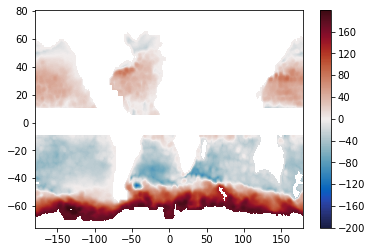

In [9]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [10]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('seismic')

In [11]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']


v = cc.querying.getvar(expt,'v',session,
                               frequency = '1 monthly',
                               start_time = '2012-04-01 00:00:00',
                               end_time = '2013-10-01 00:00:00')

v_mean_2500_1deg = v.sel(st_ocean= 2500,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')
v_mean_60_1deg = v.sel(st_ocean= 60,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')

CPU times: user 1.35 s, sys: 474 ms, total: 1.82 s
Wall time: 9.84 s


In [12]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']


v = cc.querying.getvar(expt,'v',session,
                       frequency = '1 monthly',
                       start_time = '2012-04-01 00:00:00',
                       end_time = '2013-10-01 00:00:00')


v_mean_2500_025deg = v.sel(st_ocean= 2500,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')
v_mean_60_025deg = v.sel(st_ocean= 60,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')

CPU times: user 873 ms, sys: 1.34 ms, total: 875 ms
Wall time: 8.84 s


In [13]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']

v = cc.querying.getvar(expt,'v',session,
                       frequency = '1 monthly',
                       start_time = '2012-04-01 00:00:00',
                       end_time = '2013-10-01 00:00:00')


v_mean_2500_01deg = v.sel(st_ocean= 2500,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')
v_mean_60_01deg = v.sel(st_ocean= 60,method= 'nearest').sel(time=slice(tstart,tend)).mean('time')

CPU times: user 1.13 s, sys: 177 ms, total: 1.31 s
Wall time: 8.15 s


In [14]:
gyre_psi_1deg = get_gyre_psi('1deg')
gyre_psi_025deg = get_gyre_psi('025deg')
gyre_psi_01deg = get_gyre_psi('01deg')

In [15]:
## All data is now loaded - make a dictionary for plotting
gyre_psi_dict = {'1deg': gyre_psi_1deg, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
v_mean_60_dict = {'1deg': v_mean_60_1deg, '025deg': v_mean_60_025deg, '01deg': v_mean_60_01deg}
v_mean_2500_dict = {'1deg': v_mean_2500_1deg, '025deg': v_mean_2500_025deg, '01deg': v_mean_2500_01deg}

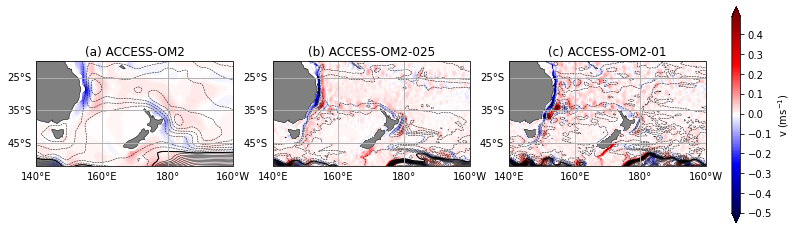

In [16]:
# EAC Region
plt.figure(figsize(12,6))
clev_60 = np.arange(-0.50,0.50,0.01)
clev2 = np.arange(-50,150.01,5)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    v_mean_60 = v_mean_60_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=v_mean_60.plot.contourf(cmap=cmp, levels=clev_60, extend='both', 
                            add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])
    
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax =ax3, orientation='vertical')
cb.ax.set_ylabel('v (ms$^{-1}$)')
    
savefigure('eac_bs_velocity_60_cycle1')

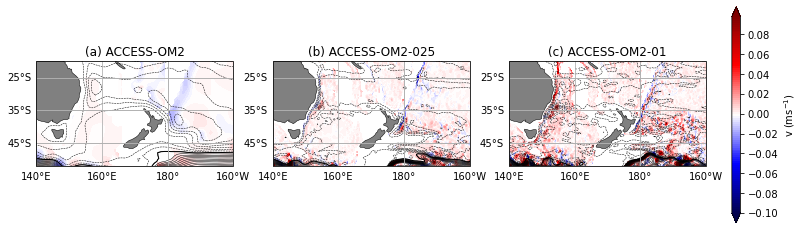

In [17]:
# EAC Region
plt.figure(figsize(12,6))
clev_2500 = np.arange(-0.10,0.10,0.002)
clev2 = np.arange(-50,150.01,5)   
    
for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    v_mean_2500 = v_mean_2500_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]   
    
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=v_mean_2500.plot.contourf(cmap=cmp, levels=clev_2500, extend='both', 
                            add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])
    
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3, orientation='vertical')
cb.ax.set_ylabel('v (ms$^{-1}$)')

savefigure('eac_bs_velocity_2500_cycle1')